In [0]:
!ls

sample_data


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
#1EgzS-nwB4ECOpgf_nzS2lMGj4ogLKVK0 Training
#1QFMZWwc0iYyVWFLzMM7DJF3W6DZqEdE9 Testing
#https://drive.google.com/open?id=1HquTQTRbiqu04S0v_kVAbdr10msBZ_Vx TRAIN
#https://drive.google.com/open?id=1BLFxvwMwxZBeb3ir93OUpZbYKYiddgDD TEST
# downloaded_train = drive.CreateFile({'id':"1EgzS-nwB4ECOpgf_nzS2lMGj4ogLKVK0"})   # replace the id with id of file you want to access
# downloaded_train.GetContentFile('BelgiumTSC_Training.zip')    
# downloaded_test = drive.CreateFile({'id':"1QFMZWwc0iYyVWFLzMM7DJF3W6DZqEdE9"})   # replace the id with id of file you want to access
# downloaded_test.GetContentFile('BelgiumTSC_Testing.zip')    
downloaded_train = drive.CreateFile({'id':"1HquTQTRbiqu04S0v_kVAbdr10msBZ_Vx"})
downloaded_train.GetContentFile('GTSRB_Final_Training_Images.zip')    
downloaded_test=drive.CreateFile({'id':"1BLFxvwMwxZBeb3ir93OUpZbYKYiddgDD"})
downloaded_test.GetContentFile('GTSRB_Final_Test_Images.zip')

In [0]:
# !mkdir G_Train
# !mkdir G_Test
!unzip -qq GTSRB_Final_Training_Images.zip -d G_Train
!unzip -qq GTSRB_Final_Test_Images.zip -d G_Test

In [0]:
 %tensorflow_version 1.x
import pickle
import os,cv2
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
from skimage import transform,exposure
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,ReLU,Flatten,BatchNormalization,Activation
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

In [0]:
def load_image(dir_path):
    all_dirs=[d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path,d))]
    labels=[]
    images=[]

    for d in all_dirs:
        label_dir=os.path.join(dir_path,d)
        file_names=[os.path.join(label_dir,f) for f in os.listdir(label_dir) if f.endswith(".ppm")]
        for f in file_names:
            im=skimage.io.imread(f)
            img=cv2.resize(im,(64,64))
            images.append(img)
            labels.append(int(d))
    return images,labels

In [0]:
# ROOT_PATH=".\\traffic"
train_data_dir = os.path.join("G_Train/GTSRB/Final_Training/Images")
test_data_dir = os.path.join("G_Test/GTSRB/Final_Test/Images/")
images,labels=load_image(train_data_dir)
# timages,tlabels=load_image(test_data_dir)

In [0]:
class AlexNet:
  def build(self,no_of_classes):
    model=Sequential()
    model.add(Conv2D(96,kernel_size=11,strides=4,input_shape=(227,227,3)))
    model.add(ReLU())
    model.add(MaxPooling2D((3,3),strides=2))
    model.add(Conv2D(256,5,padding="same"))
    model.add(ReLU())
    model.add(MaxPooling2D((3,3),strides=2))
    model.add(Conv2D(384,3,padding="same"))
    model.add(ReLU())
    model.add(Conv2D(384,3,padding="same"))
    model.add(ReLU())
    model.add(Conv2D(256,3,padding="same"))
    model.add(ReLU())
    model.add(MaxPool2D((3,3),strides=2))
    model.add(Flatten())
    model.add(Dense(4096))
    model.add(Dense(4096))
    model.add(Dense(no_of_classes,activation="softmax"))
    return model

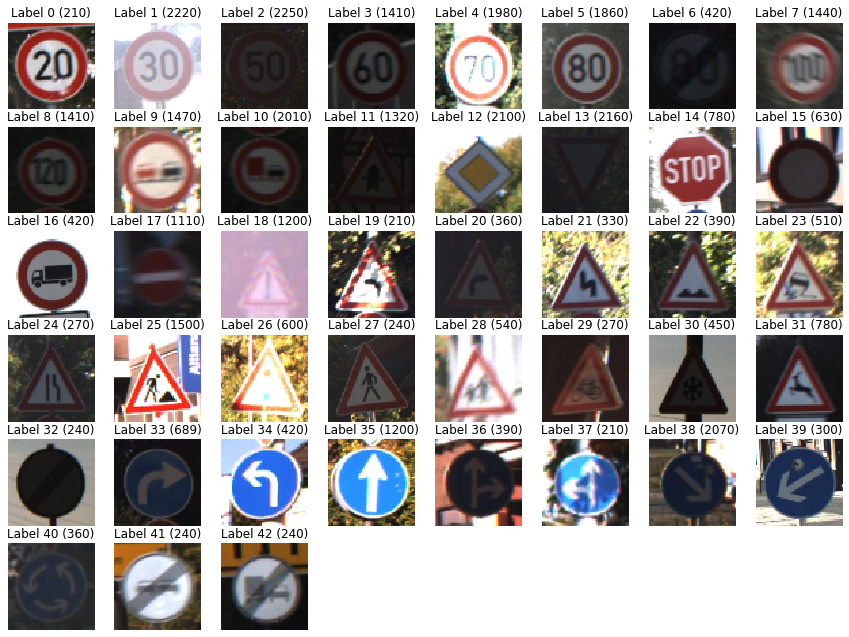

In [0]:
def display_images_and_labels(images, labels):
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

In [0]:
class TrafficNet:
  def build(self,height,width,depth,num_of_classes):
    input_shape=(height,width,depth)
    channel_dim=-1#TENSORFLOW (height,width,depth,channel)
    model=Sequential()
    model.add(Conv2D(8,3, padding="same", input_shape=input_shape))
    model.add(ReLU())
    model.add(BatchNormalization(axis=channel_dim))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(16, 3, padding="same"))
    model.add(ReLU())
    model.add(BatchNormalization(axis=channel_dim))
    model.add(Conv2D(16, 3, padding="same"))
    model.add(ReLU())
    model.add(BatchNormalization(axis=channel_dim))
    model.add(MaxPooling2D((2, 2)))
    
    # model.add(Conv2D(32,3, padding="same"))
    # model.add(ReLU())
    # model.add(BatchNormalization(axis=channel_dim))
    # model.add(Conv2D(32, 3, padding="same"))
    # model.add(ReLU())
    # model.add(BatchNormalization(axis=channel_dim))
    # model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(ReLU())
    model.add(BatchNormalization())
    # model.add(Dropout(0.5))
    
    # model.add(Flatten())
    # model.add(Dense(128))
    # model.add(ReLU())
    # model.add(BatchNormalization())
    # model.add(Dropout(0.5))
    
    model.add(Dense(num_of_classes,activation="softmax"))

    return model

In [0]:
model=TrafficNet()
model=model.build(64,64,3,43)
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])


In [0]:

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 64, 8)         224       
_________________________________________________________________
re_lu_9 (ReLU)               (None, 64, 64, 8)         0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 64, 64, 8)         32        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
re_lu_10 (ReLU)              (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 16)       

In [0]:
x_train,x_test,y_train,y_test=train_test_split(images,labels,test_size=0.2,random_state=4)
x_train=np.asarray(x_train)
y_train=np.asarray(y_train)
y_test=np.asarray(y_test)
y_test_not_categorical=y_test
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
print(y_test.shape)

(7842, 43)


In [0]:
model.fit(x_train,y_train,verbose=1,epochs=5,batch_size=300)

Epoch 1/5
31367/31367 [==============================] - 20s 624us/step - loss: 0.9861 - acc: 0.7647
Epoch 2/5
31367/31367 [==============================] - 18s 584us/step - loss: 0.0965 - acc: 0.9843
Epoch 3/5
31367/31367 [==============================] - 18s 574us/step - loss: 0.0323 - acc: 0.9967
Epoch 4/5
31367/31367 [==============================] - 19s 612us/step - loss: 0.0142 - acc: 0.9993
Epoch 5/5
31367/31367 [==============================] - 18s 584us/step - loss: 0.0069 - acc: 1.0000


In [0]:
x_test=np.asarray(x_test)
# y_test=to_categorical(y_test)

In [0]:
model.evaluate(x_test,y_test,verbose=2)


[0.04735349907946659, 0.9886508543738842]

In [0]:
y_pred=[]
for i in x_test:
  i=np.reshape(i,(1,64,64,3))
  a=np.argmax(model.predict(i))
  y_pred.append(a)
y_pred=np.asarray(y_pred)

['G_Test/GTSRB/Final_Test/Images/03776.ppm', 'G_Test/GTSRB/Final_Test/Images/01811.ppm', 'G_Test/GTSRB/Final_Test/Images/00981.ppm', 'G_Test/GTSRB/Final_Test/Images/00892.ppm', 'G_Test/GTSRB/Final_Test/Images/07023.ppm', 'G_Test/GTSRB/Final_Test/Images/04377.ppm', 'G_Test/GTSRB/Final_Test/Images/07427.ppm', 'G_Test/GTSRB/Final_Test/Images/09039.ppm', 'G_Test/GTSRB/Final_Test/Images/03008.ppm', 'G_Test/GTSRB/Final_Test/Images/08149.ppm']


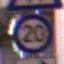

4


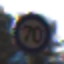

4


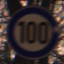

7


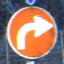

33


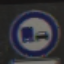

10


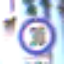

4


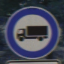

16


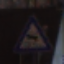

23


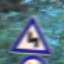

21


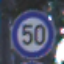

2


In [0]:
files = [os.path.join(test_data_dir,f) for f in os.listdir(test_data_dir) if f.endswith(".ppm")]
print(files[:10])
for i in range(10):
  img=skimage.io.imread(files[i])
  img=cv2.resize(img,(64,64))
  cv2_imshow(img)
  img=np.reshape(img,(1,64,64,3))
  params=np.argmax(model.predict(img))
  print(params)

In [0]:
from sklearn.metrics import accuracy_score
mat = accuracy_score(y_test_not_categorical, y_pred)
# mat = confusion_matrix(y_test_not_categorical, y_pred)
print(mat)

0.9886508543738842


In [0]:
from google.colab import files
files=files.upload()

Saving stop.jpg to stop.jpg
